# P03_01_Modeling

In [273]:
section_fig_main_title = 'P03_01_ARIMA'

In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [166]:
%config InlineBackend.figure_format = 'retina'


In [3]:
import sys
# print(sys.executable)

In [4]:
# !/Users/amin/Desktop/proj/env/bin/python -m pip install matplotlib

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

## Read data

In [7]:
csv_path = "../Data/jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

In [8]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [9]:
df.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420551 non-null  float64
 1   T (degC)         420551 non-null  float64
 2   Tpot (K)         420551 non-null  float64
 3   Tdew (degC)      420551 non-null  float64
 4   rh (%)           420551 non-null  float64
 5   VPmax (mbar)     420551 non-null  float64
 6   VPact (mbar)     420551 non-null  float64
 7   VPdef (mbar)     420551 non-null  float64
 8   sh (g/kg)        420551 non-null  float64
 9   H2OC (mmol/mol)  420551 non-null  float64
 10  rho (g/m**3)     420551 non-null  float64
 11  wv (m/s)         420551 non-null  float64
 12  max. wv (m/s)    420551 non-null  float64
 13  wd (deg)         420551 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


In [11]:
# df.corr().T

select the independent parameter and the timestamps.

In [12]:
column_name = 'T (degC)'
start = 0
end = 20000

training_df = df[column_name][start:end]

## TO BE stationary OR NOT TO BE stationary

Let's use Augmented Dickey Fuller test (ADF Test) to see if data is stationary or not.

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
adfuller_test = adfuller(df[column_name][start: end], autolag='AIC')

In [15]:
test_details = ['ADF', 'P-Vale', 'NumofLags', 'NumOfObser_ADF_regr', 'critical_values']
for i,name in enumerate(test_details):
    print(name, '  ', adfuller_test[i])

ADF    -5.948488286558909
P-Vale    2.175401053698951e-07
NumofLags    45
NumOfObser_ADF_regr    19954
critical_values    {'1%': -3.430677760921837, '5%': -2.861684858789646, '10%': -2.56684710437876}


Data is stationary (p-value < 0.05) so null hypothesis (data is not stationary) is rejected. also as was observed in EDA parts, there is no trend is observed.

## Searching for order of ARIMA model

ARIMA model is composed of three parts including autoregressive, moving average, and integrated.
auto regressive means the model considers the relationship between an obervation and some lagged observations (history). The integrated part use difference (subtraction) method to make data stationary. Moving average part, first applies a moving average on lagged observationas, second it calculates the difference between the moving average model and the residuals and, finally uses a relationship between an obervation and residuals (predicted by moving average model).

The ARIMA model has three hyper-parameters (p,d,q) which are repersentative for number of lagged observation to be used in autoregressive (so called laged order)(p), the number of times the observations are differenced (d), and the size of moving average window (q).

If the order of p,q are 5, that means the model used last 5 observation to predict the future time-stamps.


ARMA model is used for stationary data, while if the data is not stationary, the ARIMA comes to play.

In [16]:
# !/Users/amin/Desktop/proj/env/bin/python -m pip install pmdarima

In [17]:
from pmdarima import auto_arima

In [18]:
arima_model_fit = auto_arima(training_df, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8954.351, Time=17.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-115.681, Time=1.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7437.394, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6594.377, Time=2.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-117.195, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8948.137, Time=13.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7646.579, Time=6.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-8718.054, Time=19.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8966.617, Time=23.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8636.975, Time=11.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-9000.620, Time=28.02 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-9007.136, Time=28.33 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-8993.678, Time=25.72 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-9011.187, Time=33.79 sec
 ARIMA(5,1,2

It is seen that the best ARIMA model has (2,1,3) orders. The summary is provided at the following.

In [19]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                20000
Model:               SARIMAX(2, 1, 3)   Log Likelihood                4700.237
Date:                Thu, 14 Oct 2021   AIC                          -9388.473
Time:                        22:43:48   BIC                          -9341.053
Sample:                             0   HQIC                         -9372.959
                              - 20000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9857      0.001   1538.592      0.000       1.983       1.988
ar.L2         -0.9876      0.001   -767.118      0.000      -0.990      -0.985
ma.L1         -1.4953      0.003   -442.849      0.000      -1.502      -1.489
ma.L2          0.1089      0.006     18.814      0.000       0.098       0.120
ma.L3          0.3896      0.004    106.288      0.000       0.382       0.397
sigma2         0.0362      0.000    264.846      0.000       0.036       0.036
===================================================================================
Ljung-Box (L1) (Q):                   4.03   Jarque-Bera (JB):            139023.62
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.73   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The ARIMA model coeficinet are:

```ar.L1 = 1.9857, ar.L2 = -0.9876, 
ma.L1 = -1.4953, ma.L2 = 0.1089, ma.L3 = 0.3896```


## Prediction

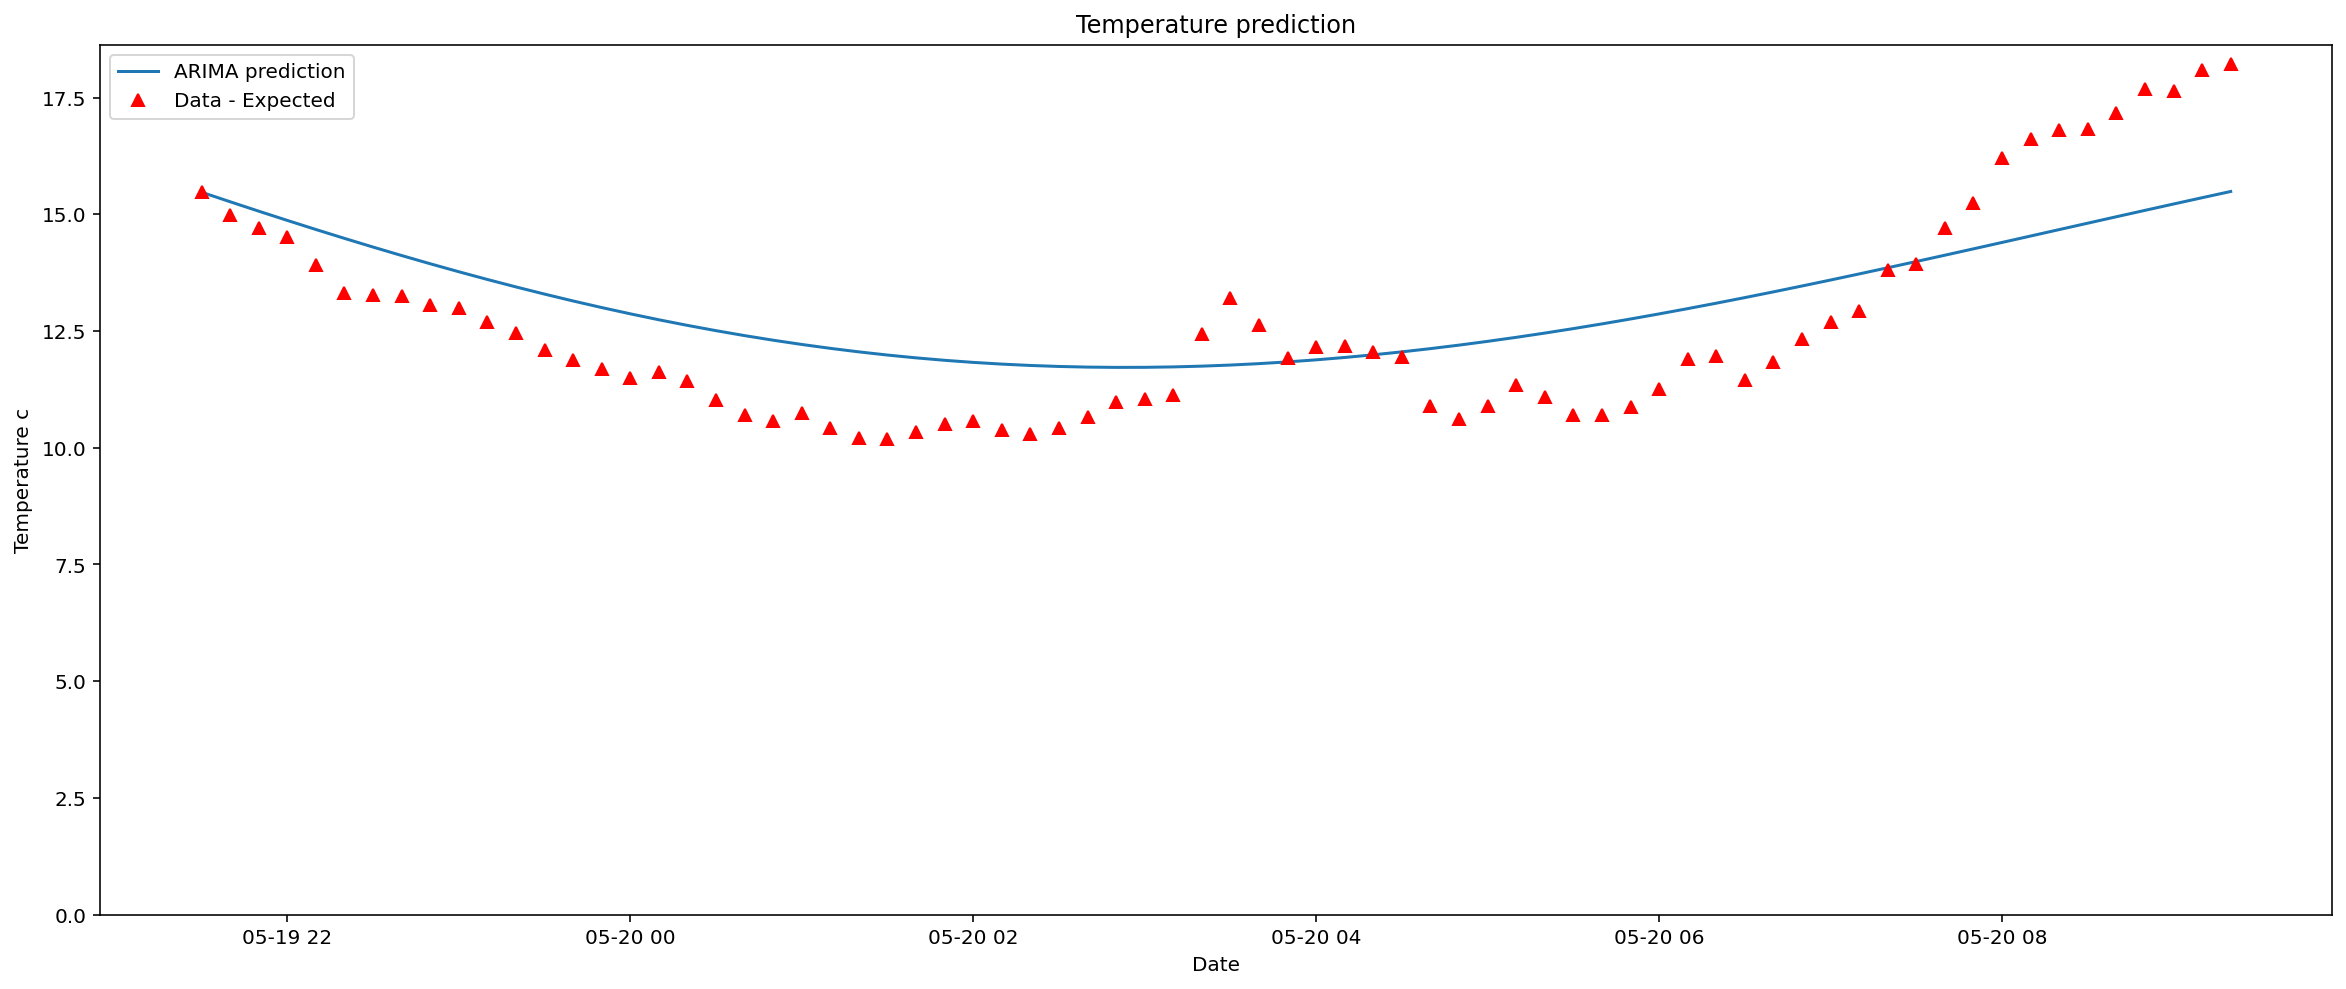

In [279]:
start = len(training_df)
ahead = 72
end = start + ahead


expected = df['T (degC)'][start:end]
predicted = arima_model_fit.predict(n_periods=ahead)

diff = predicted - expected

predicted = pd.DataFrame(predicted)
predicted.index = df[column_name][start:end].index
diff = pd.DataFrame(diff)


plt.figure(figsize=(20,8))
plt.plot(predicted, label='ARIMA prediction')
plt.plot(expected, 'r^', label='Data - Expected')


plt.xlabel('Date')
plt.ylabel('Temperature c')
plt.title("Temperature prediction")

plt.ylim(0,)

plt.legend()
plt.savefig("../Figures/" + section_fig_main_title + "Temp_esti_72ahead_1.png")

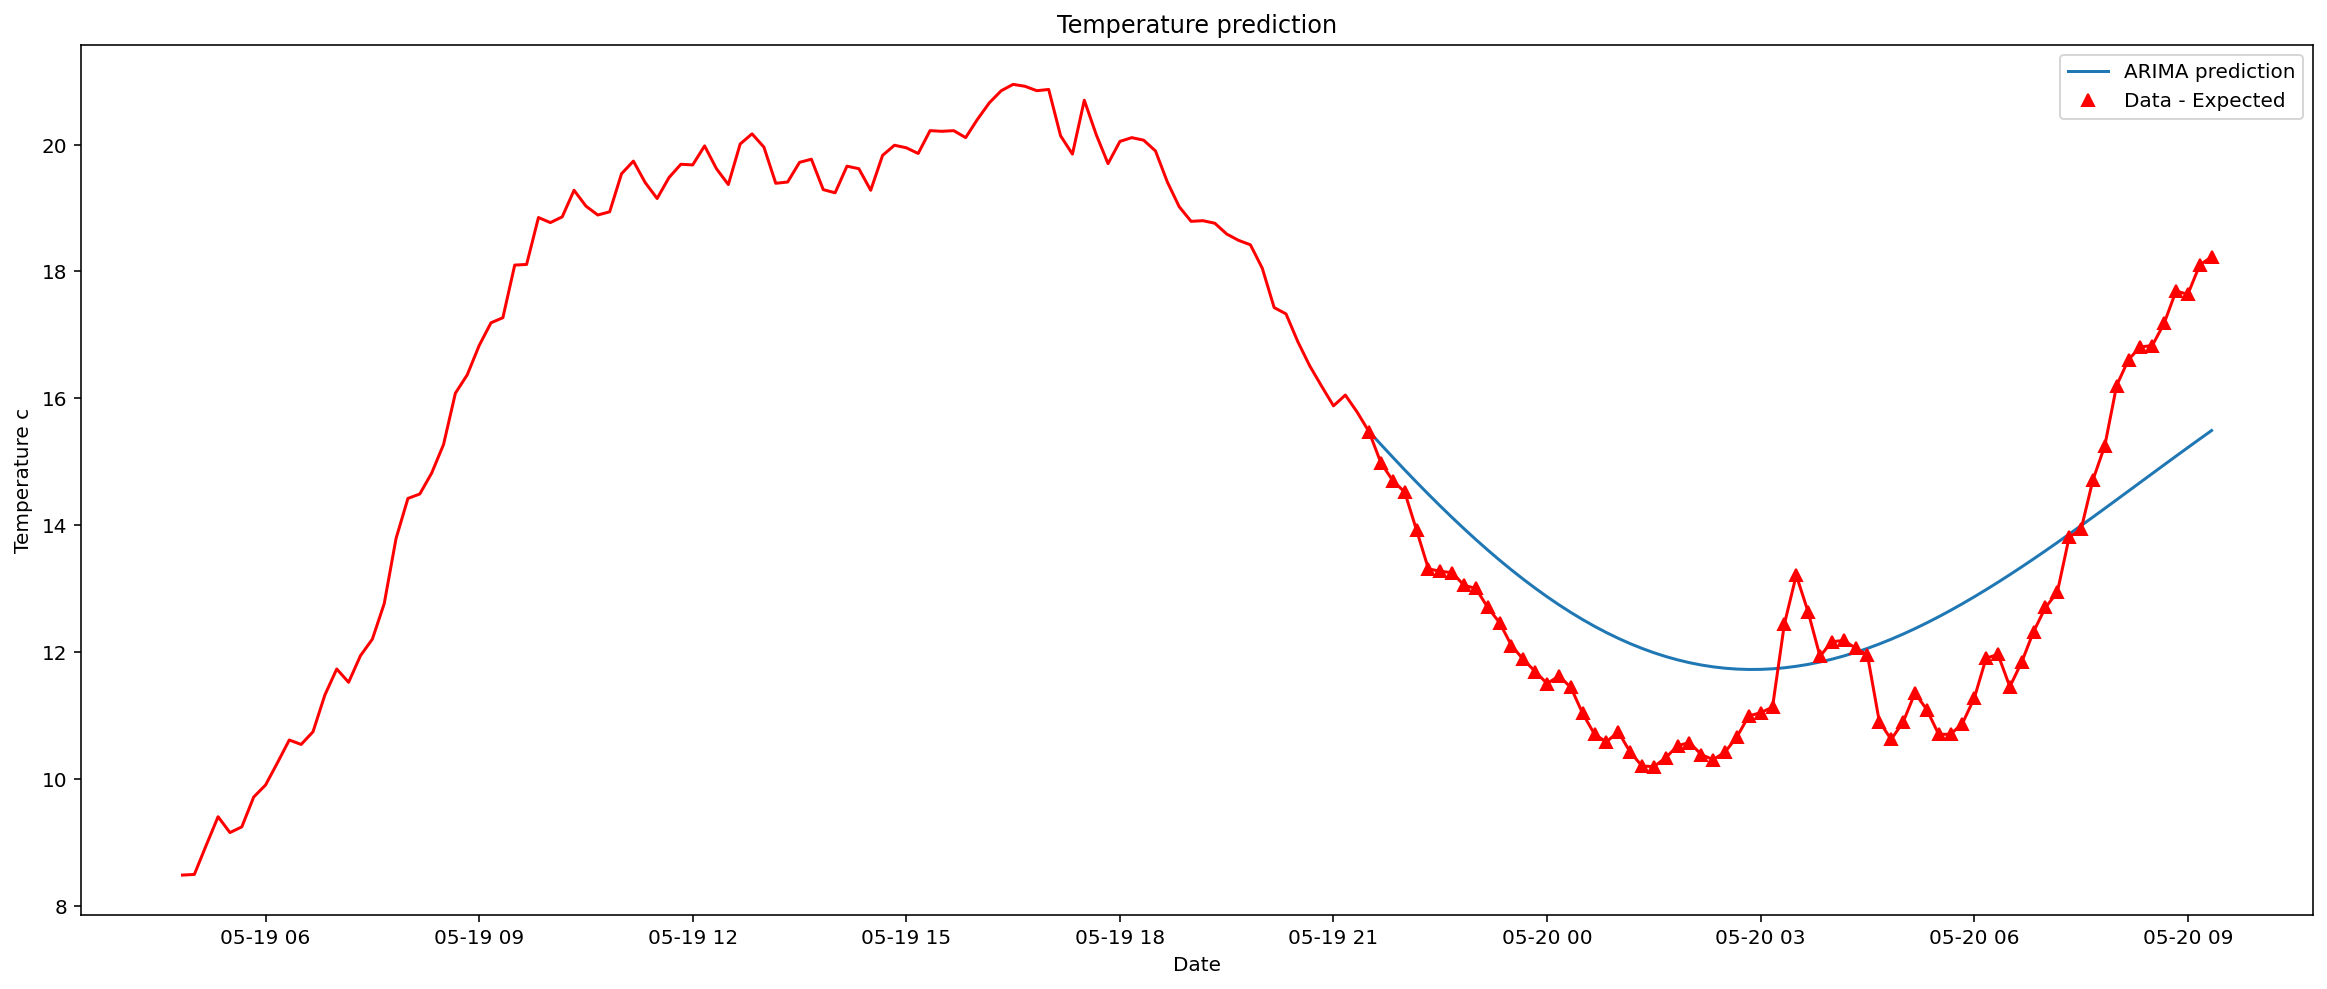

In [280]:
start = len(training_df)
ahead = 72
end = start + ahead

past = 100


expected = df['T (degC)'][start:end]
predicted = arima_model_fit.predict(n_periods=ahead)

diff = predicted - expected

predicted = pd.DataFrame(predicted)
predicted.index = df[column_name][start:end].index
diff = pd.DataFrame(diff)


plt.figure(figsize=(20,8))
plt.plot(predicted, label='ARIMA prediction')
plt.plot(expected, 'r^', label='Data - Expected')



plt.plot(df[column_name][start-past:end], c='r')


plt.xlabel('Date')
plt.ylabel('Temperature c')
plt.title("Temperature prediction")

# plt.ylim(0,)

plt.legend()

# plt.show()

plt.savefig("../Figures/" + section_fig_main_title + "Temp_esti_72ahead.png")

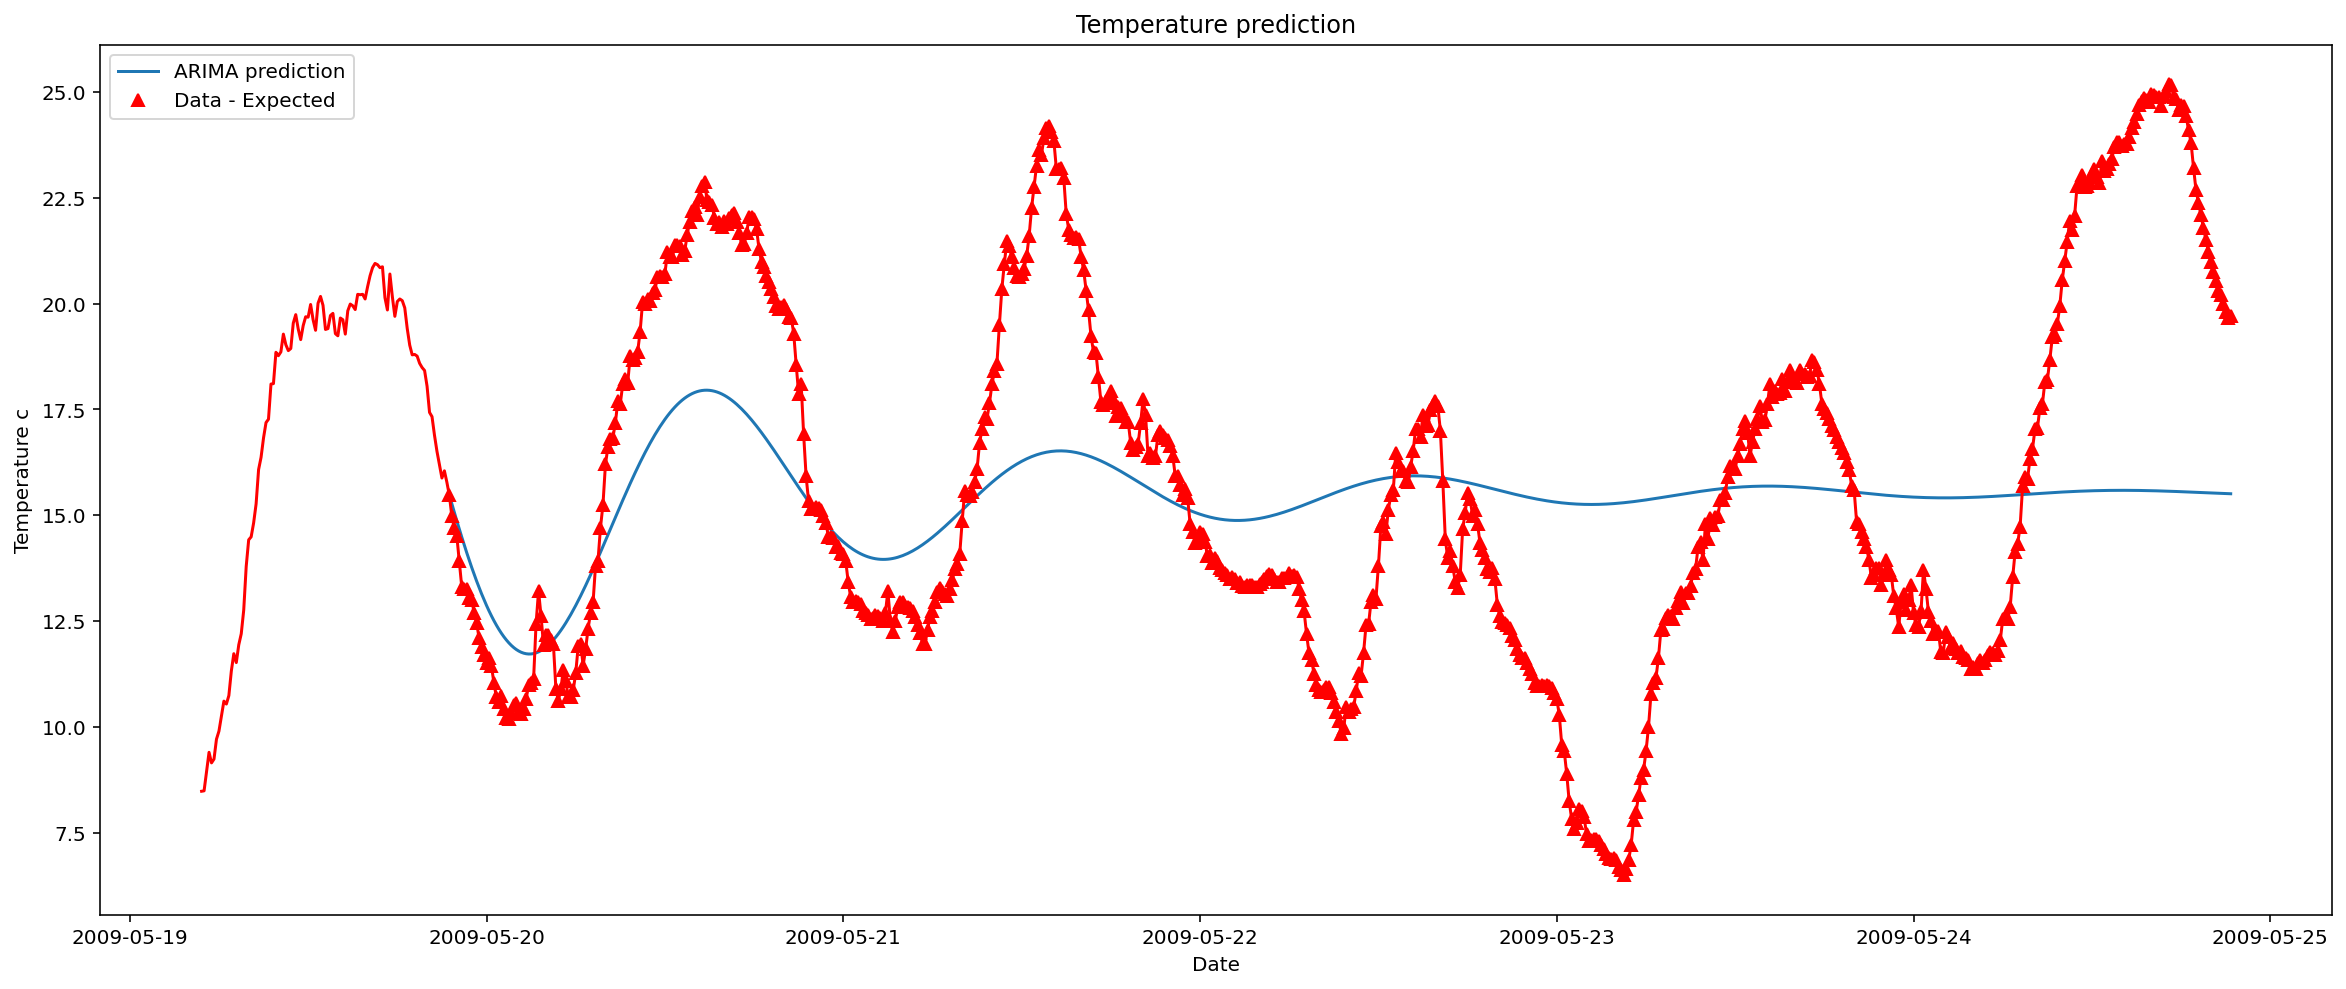

In [281]:
start = len(training_df)
ahead = 720
end = start + ahead

past = 100


expected = df['T (degC)'][start:end]
predicted = arima_model_fit.predict(n_periods=ahead)

diff = predicted - expected

predicted = pd.DataFrame(predicted)
predicted.index = df[column_name][start:end].index
diff = pd.DataFrame(diff)


plt.figure(figsize=(20,8))
plt.plot(predicted, label='ARIMA prediction')
plt.plot(expected, 'r^', label='Data - Expected')



plt.plot(df[column_name][start-past:end], c='r')


plt.xlabel('Date')
plt.ylabel('Temperature c')
plt.title("Temperature prediction")

# plt.ylim(0,)

plt.legend()
plt.savefig("../Figures/" + section_fig_main_title + "Temp_esti_720ahead.png")

as it is seen from above plot, the model error increases by time. 

The ARIMA model successfully estimates the temperature for future 72 time steamps. 
Applying the ARIMA model for higher time steamps decreases the model estimation accuracy. 